In [1]:
%pwd

'C:\\Users\\Ignacio\\Documents\\Python for Data Science\\Proyectos para escribir artículos\\Multi_time_series'

In [10]:
%cd C:\Users\Ignacio\Documents\Python for Data Science\Proyectos para escribir artículos\Multi_time_series

C:\Users\Ignacio\Documents\Python for Data Science\Proyectos para escribir artículos\Multi_time_series


In [11]:
%pwd

'C:\\Users\\Ignacio\\Documents\\Python for Data Science\\Proyectos para escribir artículos\\Multi_time_series'

# LSTM code 

Here you can check all the steps done in order to create the LSTM model.

Within the working directory we need to have a folder with the name of each country containing their data

## Import the necessary libraries

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from numpy import hstack,array
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dropout,LSTM,Dense,RepeatVector
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt

## We create our functions

##### 1-Function to split a multivariate sequence into samples

In [13]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

##### 2-Function to plot both training and validation loss

In [15]:
def plot_graphs(history, string):
  plt.figure(figsize=(11,5))

  plt.plot(history.history[string][50:])
  plt.plot(history.history['val_'+string][50:])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Load & plot our data

In [16]:
df1 = pd.read_csv('SPAIN/Data_for_Python.csv', header=0, infer_datetime_format=True, parse_dates=['DATE'], index_col=['DATE'])

fig = make_subplots(rows=2, cols=2,subplot_titles=("Unemployment (%)", "GDP (10^) ", "i rate(%)", "Debt"))
                    
# Top left
fig.add_trace(
    go.Scatter(x=df1.index, y=df1["Unem"], name="Unemployment"),
    row=1, col=1, secondary_y=False)

# Top right
fig.add_trace(
    go.Scatter(x=df1.index, y=df1["GDP"], name="GDP"),
    row=1, col=2, secondary_y=False,
)

# Bottom left
fig.add_trace(
    go.Scatter(x=df1.index, y=df1["i_rate"], name="i rate"),
    row=2, col=1, secondary_y=False,
)

# Bottom right
fig.add_trace(
    go.Scatter(x=df1.index, y=df1["Debt"], name="Debt"),
    row=2, col=2, secondary_y=False,
)
fig.update_layout(height=600, width=800, title_text="Quarterly Data: Spain")



fig.show()

### We define the number of steps in & out

In [17]:
n_steps_in, n_steps_out = 10, 8

### We create the samples

In [18]:
trainS_df,testS_df = df1[0:72], df1[(72-n_steps_in):]

trainS_df=pd.DataFrame(trainS_df[2:]).to_numpy()
testS_df=pd.DataFrame(testS_df[2:]).to_numpy()

XS, yS = split_sequences(trainS_df, n_steps_in, n_steps_out)
XS_test,yS_test = split_sequences(testS_df, n_steps_in, n_steps_out)

### We load and create the samples of every other country

In [19]:
# FRANCE
df2 = pd.read_csv('France/Data_for_Python.csv', header=0, infer_datetime_format=True, parse_dates=['DATE'], index_col=['DATE'])
trainF_df = df2[0:72]
trainF_df=trainF_df.to_numpy()
XF, yF = split_sequences(trainF_df, n_steps_in, n_steps_out)

# ITALY
df3 = pd.read_csv('Italy/Data_for_Python.csv', header=0, infer_datetime_format=True, parse_dates=['DATE'], index_col=['DATE'])
trainIT_df = df3[0:72]
trainIT_df=trainIT_df.to_numpy()
XIT, yIT = split_sequences(trainIT_df, n_steps_in, n_steps_out)

# GREECE
df4 = pd.read_csv('Greece/Data_for_Python.csv', header=0, infer_datetime_format=True, parse_dates=['DATE'], index_col=['DATE'])
trainGR_df = df4[0:68]
trainGR_df=trainGR_df.to_numpy()
XGR, yGR = split_sequences(trainGR_df, n_steps_in, n_steps_out)

# IRELAND
df5 = pd.read_csv('Ireland/Data_for_Python.csv', header=0, infer_datetime_format=True, parse_dates=['DATE'], index_col=['DATE'])
trainIR_df = df5[0:68]
trainIR_df=trainIR_df.to_numpy()
XIR, yIR = split_sequences(trainIR_df, n_steps_in, n_steps_out)

# PORTUGAL
df6 = pd.read_csv('Portugal/Data_for_Python.csv', header=0, infer_datetime_format=True, parse_dates=['DATE'], index_col=['DATE'])
trainPT_df = df6[0:68]
trainPT_df=trainPT_df.to_numpy()
XPT, yPT = split_sequences(trainPT_df, n_steps_in, n_steps_out)

## Scale the input data X

### We fit our scaler

In [20]:
O=np.concatenate((trainS_df,trainF_df,trainIT_df,trainGR_df,trainIR_df,trainPT_df))
scaler = MinMaxScaler()
scaler.fit(O)

MinMaxScaler()

###  We scale all the countries & keep the unemployment column

In [21]:
#FRANCE
for i in range(len(XF)):
   XF[i]=scaler.transform(XF[i])
yF=yF[:,:,2].reshape(len(yF),n_steps_out,1)

#ITALY
for i in range(len(XIT)):
   XIT[i]=scaler.transform(XIT[i])
yIT=yIT[:,:,2].reshape(len(yIT),n_steps_out,1)

#GREECE
for i in range(len(XGR)):
   XGR[i]=scaler.transform(XGR[i])
yGR=yGR[:,:,2].reshape(len(yGR),n_steps_out,1)

#IRELAND
for i in range(len(XIR)):
   XIR[i]=scaler.transform(XIR[i])
yIR=yIR[:,:,2].reshape(len(yIR),n_steps_out,1)

#PORTUGAL
for i in range(len(XPT)):
   XPT[i]=scaler.transform(XPT[i])
yPT=yPT[:,:,2].reshape(len(yPT),n_steps_out,1)

"""   SPAIN: TRAIN & TEST     """
for i in range(len(XS)):
   XS[i]=scaler.transform(XS[i])

for i in range(len(XS_test)):
   XS_test[i]=scaler.transform(XS_test[i])
   
yS=yS[:,:,2].reshape(len(yS),n_steps_out,1)
yS_test=yS_test[:,:,2].reshape(len(yS_test),n_steps_out,1)

"""   We create our training data    """
X=np.concatenate((XS,XF,XIT,XGR,XIR,XPT))
y=np.concatenate((yS,yF,yIT,yGR,yIR,yPT))

## Model creation
We create our model with the selected hyperparameters

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12)                816       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 12)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 12)             1200      
_________________________________________________________________
dropout (Dropout)            (None, 8, 12)             0         
_________________________________________________________________
time_distributed (TimeDistri (None, 8, 1)              13        
Total params: 2,029
Trainable params: 2,029
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3000
1/1 [==============================] - 2s 2s/step - loss: 172.6260 - mae: 11.8779 - val_loss: 219.1529 - va

1/1 [==============================] - 0s 42ms/step - loss: 171.2478 - mae: 11.8179 - val_loss: 217.3024 - val_mae: 14.7137
Epoch 113/3000
1/1 [==============================] - 0s 42ms/step - loss: 171.2289 - mae: 11.8163 - val_loss: 217.2813 - val_mae: 14.7130
Epoch 114/3000
1/1 [==============================] - 0s 50ms/step - loss: 171.1862 - mae: 11.8144 - val_loss: 217.2602 - val_mae: 14.7122
Epoch 115/3000
1/1 [==============================] - 0s 42ms/step - loss: 171.1745 - mae: 11.8137 - val_loss: 217.2389 - val_mae: 14.7115
Epoch 116/3000
1/1 [==============================] - 0s 41ms/step - loss: 171.1590 - mae: 11.8134 - val_loss: 217.2174 - val_mae: 14.7108
Epoch 117/3000
1/1 [==============================] - 0s 34ms/step - loss: 171.1188 - mae: 11.8115 - val_loss: 217.1958 - val_mae: 14.7100
Epoch 118/3000
1/1 [==============================] - 0s 41ms/step - loss: 171.0834 - mae: 11.8092 - val_loss: 217.1741 - val_mae: 14.7093
Epoch 119/3000
1/1 [======================

1/1 [==============================] - 0s 40ms/step - loss: 170.0964 - mae: 11.7656 - val_loss: 215.7973 - val_mae: 14.6622
Epoch 172/3000
1/1 [==============================] - 0s 41ms/step - loss: 170.0569 - mae: 11.7643 - val_loss: 215.7641 - val_mae: 14.6610
Epoch 173/3000
1/1 [==============================] - 0s 50ms/step - loss: 169.9845 - mae: 11.7609 - val_loss: 215.7306 - val_mae: 14.6599
Epoch 174/3000
1/1 [==============================] - 0s 59ms/step - loss: 170.0127 - mae: 11.7624 - val_loss: 215.6966 - val_mae: 14.6587
Epoch 175/3000
1/1 [==============================] - 0s 49ms/step - loss: 169.9730 - mae: 11.7601 - val_loss: 215.6623 - val_mae: 14.6575
Epoch 176/3000
1/1 [==============================] - 0s 51ms/step - loss: 169.8478 - mae: 11.7544 - val_loss: 215.6275 - val_mae: 14.6563
Epoch 177/3000
1/1 [==============================] - 0s 49ms/step - loss: 169.8551 - mae: 11.7563 - val_loss: 215.5924 - val_mae: 14.6551
Epoch 178/3000
1/1 [======================

1/1 [==============================] - 0s 52ms/step - loss: 167.8337 - mae: 11.6598 - val_loss: 212.6749 - val_mae: 14.5546
Epoch 231/3000
1/1 [==============================] - 0s 48ms/step - loss: 167.8447 - mae: 11.6620 - val_loss: 212.5821 - val_mae: 14.5514
Epoch 232/3000
1/1 [==============================] - 0s 41ms/step - loss: 167.7118 - mae: 11.6555 - val_loss: 212.4872 - val_mae: 14.5481
Epoch 233/3000
1/1 [==============================] - 0s 41ms/step - loss: 167.6231 - mae: 11.6534 - val_loss: 212.3902 - val_mae: 14.5447
Epoch 234/3000
1/1 [==============================] - 0s 43ms/step - loss: 167.4693 - mae: 11.6464 - val_loss: 212.2909 - val_mae: 14.5413
Epoch 235/3000
1/1 [==============================] - 0s 41ms/step - loss: 167.4308 - mae: 11.6431 - val_loss: 212.1890 - val_mae: 14.5377
Epoch 236/3000
1/1 [==============================] - 0s 48ms/step - loss: 167.4149 - mae: 11.6427 - val_loss: 212.0849 - val_mae: 14.5341
Epoch 237/3000
1/1 [======================

1/1 [==============================] - 0s 49ms/step - loss: 160.1226 - mae: 11.2874 - val_loss: 200.0328 - val_mae: 14.1083
Epoch 290/3000
1/1 [==============================] - 0s 43ms/step - loss: 159.6175 - mae: 11.2482 - val_loss: 199.5464 - val_mae: 14.0908
Epoch 291/3000
1/1 [==============================] - 0s 41ms/step - loss: 159.4512 - mae: 11.2417 - val_loss: 199.0359 - val_mae: 14.0723
Epoch 292/3000
1/1 [==============================] - 0s 41ms/step - loss: 158.8401 - mae: 11.2125 - val_loss: 198.5022 - val_mae: 14.0530
Epoch 293/3000
1/1 [==============================] - 0s 33ms/step - loss: 158.1922 - mae: 11.1735 - val_loss: 197.9422 - val_mae: 14.0327
Epoch 294/3000
1/1 [==============================] - 0s 35ms/step - loss: 158.2804 - mae: 11.1862 - val_loss: 197.3588 - val_mae: 14.0115
Epoch 295/3000
1/1 [==============================] - 0s 40ms/step - loss: 157.6915 - mae: 11.1411 - val_loss: 196.7481 - val_mae: 13.9893
Epoch 296/3000
1/1 [======================

1/1 [==============================] - 0s 42ms/step - loss: 137.7755 - mae: 10.0028 - val_loss: 147.4524 - val_mae: 11.9872
Epoch 349/3000
1/1 [==============================] - 0s 41ms/step - loss: 137.5335 - mae: 9.9903 - val_loss: 146.8123 - val_mae: 11.9585
Epoch 350/3000
1/1 [==============================] - 0s 42ms/step - loss: 137.5340 - mae: 9.9762 - val_loss: 146.1196 - val_mae: 11.9272
Epoch 351/3000
1/1 [==============================] - 0s 42ms/step - loss: 137.4004 - mae: 9.9978 - val_loss: 145.4170 - val_mae: 11.8954
Epoch 352/3000
1/1 [==============================] - 0s 42ms/step - loss: 136.7526 - mae: 9.9713 - val_loss: 144.6594 - val_mae: 11.8609
Epoch 353/3000
1/1 [==============================] - 0s 40ms/step - loss: 136.4884 - mae: 9.9427 - val_loss: 143.8573 - val_mae: 11.8243
Epoch 354/3000
1/1 [==============================] - 0s 34ms/step - loss: 137.0835 - mae: 9.9879 - val_loss: 143.0279 - val_mae: 11.7863
Epoch 355/3000
1/1 [============================

Epoch 468/3000
1/1 [==============================] - 0s 33ms/step - loss: 78.6127 - mae: 7.0658 - val_loss: 35.6089 - val_mae: 5.2716
Epoch 469/3000
1/1 [==============================] - 0s 25ms/step - loss: 77.5530 - mae: 6.9968 - val_loss: 35.4340 - val_mae: 5.2610
Epoch 470/3000
1/1 [==============================] - 0s 33ms/step - loss: 75.1332 - mae: 6.9172 - val_loss: 35.2450 - val_mae: 5.2487
Epoch 471/3000
1/1 [==============================] - 0s 33ms/step - loss: 74.8643 - mae: 6.9277 - val_loss: 34.9892 - val_mae: 5.2281
Epoch 472/3000
1/1 [==============================] - 0s 33ms/step - loss: 74.4780 - mae: 6.9191 - val_loss: 34.6795 - val_mae: 5.2009
Epoch 473/3000
1/1 [==============================] - 0s 33ms/step - loss: 74.6911 - mae: 6.9020 - val_loss: 34.3246 - val_mae: 5.1677
Epoch 474/3000
1/1 [==============================] - 0s 35ms/step - loss: 73.4878 - mae: 6.8268 - val_loss: 33.9525 - val_mae: 5.1319
Epoch 475/3000
1/1 [==============================] - 0

Epoch 529/3000
1/1 [==============================] - 0s 49ms/step - loss: 63.0680 - mae: 6.2916 - val_loss: 21.6325 - val_mae: 3.9032
Epoch 530/3000
1/1 [==============================] - 0s 41ms/step - loss: 65.7389 - mae: 6.3657 - val_loss: 21.3341 - val_mae: 3.8578
Epoch 531/3000
1/1 [==============================] - 0s 50ms/step - loss: 64.4118 - mae: 6.2718 - val_loss: 21.0866 - val_mae: 3.8237
Epoch 532/3000
1/1 [==============================] - 0s 44ms/step - loss: 61.2252 - mae: 6.1993 - val_loss: 20.7809 - val_mae: 3.7793
Epoch 533/3000
1/1 [==============================] - 0s 47ms/step - loss: 63.8541 - mae: 6.2417 - val_loss: 20.4347 - val_mae: 3.7275
Epoch 534/3000
1/1 [==============================] - 0s 40ms/step - loss: 63.1399 - mae: 6.1584 - val_loss: 20.1426 - val_mae: 3.6851
Epoch 535/3000
1/1 [==============================] - 0s 45ms/step - loss: 62.8366 - mae: 6.2013 - val_loss: 19.8640 - val_mae: 3.6455
Epoch 536/3000
1/1 [==============================] - 0

Epoch 590/3000
1/1 [==============================] - 0s 35ms/step - loss: 56.8671 - mae: 5.8664 - val_loss: 11.6164 - val_mae: 2.4498
Epoch 591/3000
1/1 [==============================] - 0s 40ms/step - loss: 53.8830 - mae: 5.6856 - val_loss: 11.4630 - val_mae: 2.4250
Epoch 592/3000
1/1 [==============================] - 0s 42ms/step - loss: 54.1300 - mae: 5.6844 - val_loss: 11.3229 - val_mae: 2.4039
Epoch 593/3000
1/1 [==============================] - 0s 40ms/step - loss: 55.8659 - mae: 5.7470 - val_loss: 11.1344 - val_mae: 2.3749
Epoch 594/3000
1/1 [==============================] - 0s 40ms/step - loss: 54.6452 - mae: 5.7006 - val_loss: 10.9407 - val_mae: 2.3423
Epoch 595/3000
1/1 [==============================] - 0s 45ms/step - loss: 55.6287 - mae: 5.7362 - val_loss: 10.7497 - val_mae: 2.3079
Epoch 596/3000
1/1 [==============================] - 0s 41ms/step - loss: 56.8796 - mae: 5.8377 - val_loss: 10.5880 - val_mae: 2.2791
Epoch 597/3000
1/1 [==============================] - 0

1/1 [==============================] - 0s 50ms/step - loss: 48.9885 - mae: 5.3783 - val_loss: 6.7220 - val_mae: 1.7308
Epoch 652/3000
1/1 [==============================] - 0s 34ms/step - loss: 49.4935 - mae: 5.3776 - val_loss: 6.6969 - val_mae: 1.7324
Epoch 653/3000
1/1 [==============================] - 0s 42ms/step - loss: 48.4100 - mae: 5.3601 - val_loss: 6.6660 - val_mae: 1.7322
Epoch 654/3000
1/1 [==============================] - 0s 32ms/step - loss: 50.1453 - mae: 5.4241 - val_loss: 6.6212 - val_mae: 1.7294
Epoch 655/3000
1/1 [==============================] - 0s 34ms/step - loss: 49.1865 - mae: 5.3742 - val_loss: 6.5735 - val_mae: 1.7255
Epoch 656/3000
1/1 [==============================] - 0s 33ms/step - loss: 49.7893 - mae: 5.4417 - val_loss: 6.5099 - val_mae: 1.7177
Epoch 657/3000
1/1 [==============================] - 0s 33ms/step - loss: 49.2033 - mae: 5.3432 - val_loss: 6.4408 - val_mae: 1.7091
Epoch 658/3000
1/1 [==============================] - 0s 29ms/step - loss: 46

Epoch 712/3000
1/1 [==============================] - 0s 49ms/step - loss: 46.2676 - mae: 5.2352 - val_loss: 5.2463 - val_mae: 1.6061
Epoch 713/3000
1/1 [==============================] - 0s 42ms/step - loss: 46.1235 - mae: 5.2170 - val_loss: 5.2016 - val_mae: 1.6007
Epoch 714/3000
1/1 [==============================] - 0s 41ms/step - loss: 45.1886 - mae: 5.1011 - val_loss: 5.2024 - val_mae: 1.6038
Epoch 715/3000
1/1 [==============================] - 0s 33ms/step - loss: 45.2662 - mae: 5.1354 - val_loss: 5.1726 - val_mae: 1.5999
Epoch 716/3000
1/1 [==============================] - 0s 41ms/step - loss: 44.8113 - mae: 5.1203 - val_loss: 5.1423 - val_mae: 1.5950
Epoch 717/3000
1/1 [==============================] - 0s 42ms/step - loss: 48.5327 - mae: 5.3331 - val_loss: 5.0563 - val_mae: 1.5776
Epoch 718/3000
1/1 [==============================] - 0s 41ms/step - loss: 48.7069 - mae: 5.4202 - val_loss: 4.9823 - val_mae: 1.5620
Epoch 719/3000
1/1 [==============================] - 0s 33ms/

1/1 [==============================] - 0s 44ms/step - loss: 44.6464 - mae: 5.0726 - val_loss: 5.2891 - val_mae: 1.7762
Epoch 835/3000
1/1 [==============================] - 0s 40ms/step - loss: 45.0499 - mae: 5.0809 - val_loss: 5.4623 - val_mae: 1.8074
Epoch 836/3000
1/1 [==============================] - 0s 43ms/step - loss: 42.6979 - mae: 4.9361 - val_loss: 5.4621 - val_mae: 1.8110
Epoch 837/3000
1/1 [==============================] - 0s 41ms/step - loss: 42.8028 - mae: 4.9527 - val_loss: 5.6295 - val_mae: 1.8370
Epoch 838/3000
1/1 [==============================] - 0s 43ms/step - loss: 41.6472 - mae: 4.8789 - val_loss: 5.9500 - val_mae: 1.8819
Epoch 839/3000
1/1 [==============================] - 0s 42ms/step - loss: 42.0737 - mae: 4.9246 - val_loss: 5.8713 - val_mae: 1.8734
Epoch 840/3000
1/1 [==============================] - 0s 42ms/step - loss: 40.8642 - mae: 4.8744 - val_loss: 5.7604 - val_mae: 1.8612
Epoch 841/3000
1/1 [==============================] - 0s 33ms/step - loss: 43

1/1 [==============================] - 0s 34ms/step - loss: 38.1864 - mae: 4.6455 - val_loss: 7.3234 - val_mae: 2.2062
Epoch 957/3000
1/1 [==============================] - 0s 41ms/step - loss: 38.7191 - mae: 4.7066 - val_loss: 6.6326 - val_mae: 2.1239
Epoch 958/3000
1/1 [==============================] - 0s 41ms/step - loss: 39.7749 - mae: 4.7934 - val_loss: 5.6440 - val_mae: 1.9867
Epoch 959/3000
1/1 [==============================] - 0s 42ms/step - loss: 38.4686 - mae: 4.7313 - val_loss: 5.3898 - val_mae: 1.9478
Epoch 960/3000
1/1 [==============================] - 0s 42ms/step - loss: 40.1558 - mae: 4.7933 - val_loss: 5.4454 - val_mae: 1.9563
Epoch 961/3000
1/1 [==============================] - 0s 41ms/step - loss: 39.6605 - mae: 4.7914 - val_loss: 5.4994 - val_mae: 1.9622
Epoch 962/3000
1/1 [==============================] - 0s 43ms/step - loss: 38.3843 - mae: 4.6717 - val_loss: 5.6947 - val_mae: 1.9891
Epoch 963/3000
1/1 [==============================] - 0s 42ms/step - loss: 39

1/1 [==============================] - 0s 32ms/step - loss: 36.5836 - mae: 4.6054 - val_loss: 11.3125 - val_mae: 2.7839
Epoch 1077/3000
1/1 [==============================] - 0s 50ms/step - loss: 37.2242 - mae: 4.6245 - val_loss: 10.3291 - val_mae: 2.6652
Epoch 1078/3000
1/1 [==============================] - 0s 42ms/step - loss: 39.3954 - mae: 4.7343 - val_loss: 8.9142 - val_mae: 2.4904
Epoch 1079/3000
1/1 [==============================] - 0s 33ms/step - loss: 38.1462 - mae: 4.6663 - val_loss: 7.6426 - val_mae: 2.3220
Epoch 1080/3000
1/1 [==============================] - 0s 42ms/step - loss: 38.2807 - mae: 4.6626 - val_loss: 7.2105 - val_mae: 2.2588
Epoch 1081/3000
1/1 [==============================] - 0s 42ms/step - loss: 37.8902 - mae: 4.6829 - val_loss: 7.1572 - val_mae: 2.2458
Epoch 1082/3000
1/1 [==============================] - 0s 38ms/step - loss: 38.2157 - mae: 4.6545 - val_loss: 7.6793 - val_mae: 2.3125
Epoch 1083/3000
1/1 [==============================] - 0s 45ms/step -

1/1 [==============================] - 0s 42ms/step - loss: 35.4198 - mae: 4.5418 - val_loss: 12.8810 - val_mae: 3.0426
Epoch 1197/3000
1/1 [==============================] - 0s 41ms/step - loss: 35.4386 - mae: 4.5236 - val_loss: 14.0443 - val_mae: 3.1566
Epoch 1198/3000
1/1 [==============================] - 0s 42ms/step - loss: 36.6553 - mae: 4.5652 - val_loss: 14.6269 - val_mae: 3.2062
Epoch 1199/3000
1/1 [==============================] - 0s 41ms/step - loss: 36.5420 - mae: 4.5316 - val_loss: 13.0354 - val_mae: 3.0418
Epoch 1200/3000
1/1 [==============================] - 0s 46ms/step - loss: 37.6507 - mae: 4.6553 - val_loss: 11.8157 - val_mae: 2.9086
Epoch 1201/3000
1/1 [==============================] - 0s 45ms/step - loss: 34.9214 - mae: 4.4895 - val_loss: 11.0971 - val_mae: 2.8232
Epoch 1202/3000
1/1 [==============================] - 0s 42ms/step - loss: 36.0201 - mae: 4.5110 - val_loss: 11.3755 - val_mae: 2.8531
Epoch 1203/3000
1/1 [==============================] - 0s 42ms/s

1/1 [==============================] - 0s 33ms/step - loss: 32.8734 - mae: 4.2972 - val_loss: 9.4437 - val_mae: 2.6291
Epoch 1317/3000
1/1 [==============================] - 0s 33ms/step - loss: 32.7577 - mae: 4.3423 - val_loss: 10.6339 - val_mae: 2.8038
Epoch 1318/3000
1/1 [==============================] - 0s 42ms/step - loss: 31.6729 - mae: 4.2519 - val_loss: 12.3000 - val_mae: 3.0157
Epoch 1319/3000
1/1 [==============================] - 0s 41ms/step - loss: 33.3467 - mae: 4.3541 - val_loss: 13.6553 - val_mae: 3.1667
Epoch 1320/3000
1/1 [==============================] - 0s 42ms/step - loss: 34.1529 - mae: 4.4014 - val_loss: 12.9311 - val_mae: 3.0866
Epoch 1321/3000
1/1 [==============================] - 0s 34ms/step - loss: 34.9788 - mae: 4.4853 - val_loss: 12.4674 - val_mae: 3.0334
Epoch 1322/3000
1/1 [==============================] - 0s 41ms/step - loss: 36.8363 - mae: 4.5500 - val_loss: 11.8645 - val_mae: 2.9640
Epoch 1323/3000
1/1 [==============================] - 0s 33ms/st

1/1 [==============================] - 0s 42ms/step - loss: 34.6858 - mae: 4.4401 - val_loss: 7.6901 - val_mae: 2.3356
Epoch 1437/3000
1/1 [==============================] - 0s 33ms/step - loss: 32.3150 - mae: 4.2617 - val_loss: 9.1964 - val_mae: 2.6018
Epoch 1438/3000
1/1 [==============================] - 0s 34ms/step - loss: 32.2472 - mae: 4.2722 - val_loss: 9.6604 - val_mae: 2.6770
Epoch 1439/3000
1/1 [==============================] - 0s 34ms/step - loss: 33.1557 - mae: 4.3392 - val_loss: 8.2885 - val_mae: 2.4533
Epoch 1440/3000
1/1 [==============================] - 0s 33ms/step - loss: 31.8602 - mae: 4.2669 - val_loss: 7.2352 - val_mae: 2.2479
Epoch 1441/3000
1/1 [==============================] - 0s 42ms/step - loss: 33.1940 - mae: 4.3894 - val_loss: 6.7649 - val_mae: 2.1437
Epoch 1442/3000
1/1 [==============================] - 0s 41ms/step - loss: 35.0581 - mae: 4.3976 - val_loss: 6.8122 - val_mae: 2.1484
Epoch 1443/3000
1/1 [==============================] - 0s 43ms/step - l

Epoch 1497/3000
1/1 [==============================] - 0s 33ms/step - loss: 30.9187 - mae: 4.2025 - val_loss: 5.3835 - val_mae: 1.9542
Epoch 1498/3000
1/1 [==============================] - 0s 42ms/step - loss: 30.6526 - mae: 4.1766 - val_loss: 5.1892 - val_mae: 1.9144
Epoch 1499/3000
1/1 [==============================] - 0s 33ms/step - loss: 32.5924 - mae: 4.3252 - val_loss: 5.6663 - val_mae: 2.0215
Epoch 1500/3000
1/1 [==============================] - 0s 40ms/step - loss: 31.3562 - mae: 4.2083 - val_loss: 6.1503 - val_mae: 2.1189
Epoch 1501/3000
1/1 [==============================] - 0s 34ms/step - loss: 31.8385 - mae: 4.2584 - val_loss: 5.9376 - val_mae: 2.0690
Epoch 1502/3000
1/1 [==============================] - 0s 45ms/step - loss: 32.5380 - mae: 4.3193 - val_loss: 6.2543 - val_mae: 2.1287
Epoch 1503/3000
1/1 [==============================] - 0s 42ms/step - loss: 32.8015 - mae: 4.3229 - val_loss: 6.4976 - val_mae: 2.1724
Epoch 1504/3000
1/1 [==============================] - 

Epoch 1558/3000
1/1 [==============================] - 0s 36ms/step - loss: 32.2789 - mae: 4.2855 - val_loss: 4.6197 - val_mae: 1.7589
Epoch 1559/3000
1/1 [==============================] - 0s 39ms/step - loss: 30.9466 - mae: 4.2017 - val_loss: 4.5915 - val_mae: 1.7467
Epoch 1560/3000
1/1 [==============================] - 0s 44ms/step - loss: 32.1573 - mae: 4.2596 - val_loss: 4.8789 - val_mae: 1.8116
Epoch 1561/3000
1/1 [==============================] - 0s 41ms/step - loss: 31.7782 - mae: 4.2326 - val_loss: 5.3728 - val_mae: 1.9303
Epoch 1562/3000
1/1 [==============================] - 0s 43ms/step - loss: 31.7165 - mae: 4.2463 - val_loss: 5.8581 - val_mae: 2.0440
Epoch 1563/3000
1/1 [==============================] - 0s 41ms/step - loss: 30.5926 - mae: 4.2207 - val_loss: 5.4228 - val_mae: 1.9553
Epoch 1564/3000
1/1 [==============================] - 0s 41ms/step - loss: 31.4483 - mae: 4.2491 - val_loss: 4.6392 - val_mae: 1.7882
Epoch 1565/3000
1/1 [==============================] - 

Epoch 1619/3000
1/1 [==============================] - 0s 42ms/step - loss: 30.5795 - mae: 4.1637 - val_loss: 3.3982 - val_mae: 1.5279
Epoch 1620/3000
1/1 [==============================] - 0s 41ms/step - loss: 31.2291 - mae: 4.1694 - val_loss: 3.2522 - val_mae: 1.4996
Epoch 1621/3000
1/1 [==============================] - 0s 49ms/step - loss: 31.8788 - mae: 4.2298 - val_loss: 3.4010 - val_mae: 1.5308
Epoch 1622/3000
1/1 [==============================] - 0s 44ms/step - loss: 32.0980 - mae: 4.2624 - val_loss: 3.6321 - val_mae: 1.5782
Epoch 1623/3000
1/1 [==============================] - 0s 41ms/step - loss: 31.5517 - mae: 4.2377 - val_loss: 3.4968 - val_mae: 1.5488
Epoch 1624/3000
1/1 [==============================] - 0s 42ms/step - loss: 30.6343 - mae: 4.1336 - val_loss: 3.2982 - val_mae: 1.5092
Epoch 1625/3000
1/1 [==============================] - 0s 34ms/step - loss: 30.8266 - mae: 4.1426 - val_loss: 3.2485 - val_mae: 1.5016
Epoch 1626/3000
1/1 [==============================] - 

Epoch 1740/3000
1/1 [==============================] - 0s 37ms/step - loss: 30.5880 - mae: 4.1625 - val_loss: 4.0434 - val_mae: 1.6994
Epoch 1741/3000
1/1 [==============================] - 0s 46ms/step - loss: 30.8433 - mae: 4.1798 - val_loss: 3.3731 - val_mae: 1.5436
Epoch 1742/3000
1/1 [==============================] - 0s 42ms/step - loss: 30.3057 - mae: 4.1679 - val_loss: 2.7025 - val_mae: 1.3888
Epoch 1743/3000
1/1 [==============================] - 0s 41ms/step - loss: 28.9767 - mae: 4.0982 - val_loss: 2.2929 - val_mae: 1.2853
Epoch 1744/3000
1/1 [==============================] - 0s 39ms/step - loss: 30.8144 - mae: 4.1592 - val_loss: 2.2339 - val_mae: 1.2679
Epoch 1745/3000
1/1 [==============================] - 0s 36ms/step - loss: 30.4398 - mae: 4.1764 - val_loss: 2.2285 - val_mae: 1.2645
Epoch 1746/3000
1/1 [==============================] - 0s 43ms/step - loss: 30.7315 - mae: 4.1546 - val_loss: 2.3594 - val_mae: 1.2992
Epoch 1747/3000
1/1 [==============================] - 

Epoch 1801/3000
1/1 [==============================] - 0s 33ms/step - loss: 29.8439 - mae: 4.1379 - val_loss: 2.9415 - val_mae: 1.4428
Epoch 1802/3000
1/1 [==============================] - 0s 34ms/step - loss: 30.4221 - mae: 4.2214 - val_loss: 2.3441 - val_mae: 1.2978
Epoch 1803/3000
1/1 [==============================] - 0s 42ms/step - loss: 30.0317 - mae: 4.0751 - val_loss: 2.0022 - val_mae: 1.1872
Epoch 1804/3000
1/1 [==============================] - 0s 34ms/step - loss: 32.6209 - mae: 4.3351 - val_loss: 1.9445 - val_mae: 1.1721
Epoch 1805/3000
1/1 [==============================] - 0s 42ms/step - loss: 29.8659 - mae: 4.1200 - val_loss: 2.0068 - val_mae: 1.1933
Epoch 1806/3000
1/1 [==============================] - 0s 42ms/step - loss: 30.8801 - mae: 4.1662 - val_loss: 2.2722 - val_mae: 1.2764
Epoch 1807/3000
1/1 [==============================] - 0s 42ms/step - loss: 29.7374 - mae: 4.0629 - val_loss: 2.8026 - val_mae: 1.4329
Epoch 1808/3000
1/1 [==============================] - 

Epoch 1922/3000
1/1 [==============================] - 0s 42ms/step - loss: 30.2421 - mae: 4.1556 - val_loss: 3.4199 - val_mae: 1.5564
Epoch 1923/3000
1/1 [==============================] - 0s 41ms/step - loss: 30.0845 - mae: 4.1460 - val_loss: 3.2894 - val_mae: 1.5274
Epoch 1924/3000
1/1 [==============================] - 0s 33ms/step - loss: 30.1438 - mae: 4.1362 - val_loss: 2.7088 - val_mae: 1.4122
Epoch 1925/3000
1/1 [==============================] - 0s 34ms/step - loss: 28.8494 - mae: 4.0006 - val_loss: 2.1728 - val_mae: 1.2695
Epoch 1926/3000
1/1 [==============================] - 0s 42ms/step - loss: 29.3507 - mae: 4.1066 - val_loss: 1.9698 - val_mae: 1.2031
Epoch 1927/3000
1/1 [==============================] - 0s 41ms/step - loss: 26.9313 - mae: 3.9004 - val_loss: 1.8962 - val_mae: 1.1782
Epoch 1928/3000
1/1 [==============================] - 0s 43ms/step - loss: 30.1823 - mae: 4.1628 - val_loss: 1.9105 - val_mae: 1.1851
Epoch 1929/3000
1/1 [==============================] - 

Epoch 1983/3000
1/1 [==============================] - 0s 33ms/step - loss: 29.2101 - mae: 4.1225 - val_loss: 2.8558 - val_mae: 1.4632
Epoch 1984/3000
1/1 [==============================] - 0s 40ms/step - loss: 29.6040 - mae: 4.0941 - val_loss: 2.3148 - val_mae: 1.3174
Epoch 1985/3000
1/1 [==============================] - 0s 35ms/step - loss: 28.8820 - mae: 4.0440 - val_loss: 1.9217 - val_mae: 1.1887
Epoch 1986/3000
1/1 [==============================] - 0s 41ms/step - loss: 29.9776 - mae: 4.0632 - val_loss: 1.7989 - val_mae: 1.1465
Epoch 1987/3000
1/1 [==============================] - 0s 42ms/step - loss: 29.7470 - mae: 4.1025 - val_loss: 1.7560 - val_mae: 1.1314
Epoch 1988/3000
1/1 [==============================] - 0s 50ms/step - loss: 28.9368 - mae: 4.0591 - val_loss: 1.8093 - val_mae: 1.1525
Epoch 1989/3000
1/1 [==============================] - 0s 42ms/step - loss: 29.9034 - mae: 4.1024 - val_loss: 1.9053 - val_mae: 1.1880
Epoch 1990/3000
1/1 [==============================] - 

1/1 [==============================] - 0s 42ms/step - loss: 29.4700 - mae: 4.0044 - val_loss: 1.6570 - val_mae: 1.0932
Epoch 2104/3000
1/1 [==============================] - 0s 33ms/step - loss: 28.3846 - mae: 4.0204 - val_loss: 1.7201 - val_mae: 1.1255
Epoch 2105/3000
1/1 [==============================] - 0s 33ms/step - loss: 27.5671 - mae: 3.9726 - val_loss: 1.8453 - val_mae: 1.1758
Epoch 2106/3000
1/1 [==============================] - 0s 40ms/step - loss: 30.8438 - mae: 4.1143 - val_loss: 1.9405 - val_mae: 1.2126
Epoch 2107/3000
1/1 [==============================] - 0s 51ms/step - loss: 27.6355 - mae: 3.9592 - val_loss: 1.9275 - val_mae: 1.2088
Epoch 2108/3000
1/1 [==============================] - 0s 50ms/step - loss: 28.9230 - mae: 4.1426 - val_loss: 1.7833 - val_mae: 1.1379
Epoch 2109/3000
1/1 [==============================] - 0s 43ms/step - loss: 28.5727 - mae: 3.9881 - val_loss: 1.7690 - val_mae: 1.1000
Epoch 2110/3000
1/1 [==============================] - 0s 41ms/step - l

Epoch 2224/3000
1/1 [==============================] - 0s 40ms/step - loss: 30.5529 - mae: 4.1241 - val_loss: 1.8678 - val_mae: 1.0694
Epoch 2225/3000
1/1 [==============================] - 0s 43ms/step - loss: 29.0312 - mae: 4.0365 - val_loss: 1.9031 - val_mae: 1.0979
Epoch 2226/3000
1/1 [==============================] - 0s 42ms/step - loss: 26.6815 - mae: 3.9424 - val_loss: 1.9515 - val_mae: 1.1475
Epoch 2227/3000
1/1 [==============================] - 0s 42ms/step - loss: 29.1923 - mae: 4.0174 - val_loss: 2.0071 - val_mae: 1.1971
Epoch 2228/3000
1/1 [==============================] - 0s 42ms/step - loss: 28.4291 - mae: 4.0288 - val_loss: 2.0922 - val_mae: 1.2443
Epoch 2229/3000
1/1 [==============================] - 0s 33ms/step - loss: 28.4410 - mae: 3.9933 - val_loss: 2.3034 - val_mae: 1.3320
Epoch 2230/3000
1/1 [==============================] - 0s 41ms/step - loss: 28.7008 - mae: 4.0809 - val_loss: 2.1276 - val_mae: 1.2549
Epoch 2231/3000
1/1 [==============================] - 

Epoch 2345/3000
1/1 [==============================] - 0s 34ms/step - loss: 29.5068 - mae: 4.0782 - val_loss: 1.8329 - val_mae: 1.1587
Epoch 2346/3000
1/1 [==============================] - 0s 43ms/step - loss: 30.0073 - mae: 4.0758 - val_loss: 1.8053 - val_mae: 1.1174
Epoch 2347/3000
1/1 [==============================] - 0s 41ms/step - loss: 29.1475 - mae: 4.0273 - val_loss: 1.8111 - val_mae: 1.1073
Epoch 2348/3000
1/1 [==============================] - 0s 42ms/step - loss: 29.9123 - mae: 4.0910 - val_loss: 1.8571 - val_mae: 1.1436
Epoch 2349/3000
1/1 [==============================] - 0s 33ms/step - loss: 28.8845 - mae: 4.0662 - val_loss: 1.9871 - val_mae: 1.2179
Epoch 2350/3000
1/1 [==============================] - 0s 41ms/step - loss: 29.1747 - mae: 4.0670 - val_loss: 2.1564 - val_mae: 1.2814
Epoch 2351/3000
1/1 [==============================] - 0s 42ms/step - loss: 30.6455 - mae: 4.0997 - val_loss: 2.1826 - val_mae: 1.2885
Epoch 2352/3000
1/1 [==============================] - 

Epoch 2406/3000
1/1 [==============================] - 0s 32ms/step - loss: 29.5642 - mae: 4.0181 - val_loss: 1.8599 - val_mae: 1.0999
Epoch 2407/3000
1/1 [==============================] - 0s 44ms/step - loss: 30.7935 - mae: 4.1738 - val_loss: 1.9148 - val_mae: 1.1668
Epoch 2408/3000
1/1 [==============================] - 0s 34ms/step - loss: 27.0773 - mae: 3.9188 - val_loss: 2.0253 - val_mae: 1.2401
Epoch 2409/3000
1/1 [==============================] - 0s 41ms/step - loss: 27.7444 - mae: 3.9932 - val_loss: 1.9982 - val_mae: 1.2274
Epoch 2410/3000
1/1 [==============================] - 0s 43ms/step - loss: 28.9410 - mae: 4.0627 - val_loss: 1.9562 - val_mae: 1.1943
Epoch 2411/3000
1/1 [==============================] - 0s 33ms/step - loss: 28.9426 - mae: 4.0520 - val_loss: 1.9236 - val_mae: 1.1622
Epoch 2412/3000
1/1 [==============================] - 0s 42ms/step - loss: 28.1596 - mae: 3.9675 - val_loss: 1.9348 - val_mae: 1.1608
Epoch 2413/3000
1/1 [==============================] - 

Epoch 2467/3000
1/1 [==============================] - 0s 49ms/step - loss: 30.9438 - mae: 4.1458 - val_loss: 1.7883 - val_mae: 1.0833
Epoch 2468/3000
1/1 [==============================] - 0s 42ms/step - loss: 27.9451 - mae: 3.9572 - val_loss: 1.8391 - val_mae: 1.1564
Epoch 2469/3000
1/1 [==============================] - 0s 33ms/step - loss: 29.9330 - mae: 4.0849 - val_loss: 2.0626 - val_mae: 1.2584
Epoch 2470/3000
1/1 [==============================] - 0s 33ms/step - loss: 29.4161 - mae: 3.9866 - val_loss: 2.1716 - val_mae: 1.2938
Epoch 2471/3000
1/1 [==============================] - 0s 42ms/step - loss: 29.7839 - mae: 4.0829 - val_loss: 2.2287 - val_mae: 1.3097
Epoch 2472/3000
1/1 [==============================] - 0s 33ms/step - loss: 30.2215 - mae: 4.1122 - val_loss: 2.1193 - val_mae: 1.2641
Epoch 2473/3000
1/1 [==============================] - 0s 42ms/step - loss: 28.3768 - mae: 3.9971 - val_loss: 2.0484 - val_mae: 1.2095
Epoch 2474/3000
1/1 [==============================] - 

Epoch 2528/3000
1/1 [==============================] - 0s 37ms/step - loss: 30.5489 - mae: 4.1307 - val_loss: 1.8374 - val_mae: 1.0938
Epoch 2529/3000
1/1 [==============================] - 0s 49ms/step - loss: 28.3878 - mae: 3.9908 - val_loss: 1.8980 - val_mae: 1.0724
Epoch 2530/3000
1/1 [==============================] - 0s 40ms/step - loss: 29.3008 - mae: 4.0650 - val_loss: 1.9367 - val_mae: 1.0879
Epoch 2531/3000
1/1 [==============================] - 0s 33ms/step - loss: 29.2366 - mae: 3.9936 - val_loss: 1.9624 - val_mae: 1.1209
Epoch 2532/3000
1/1 [==============================] - 0s 42ms/step - loss: 29.6271 - mae: 3.9974 - val_loss: 1.9708 - val_mae: 1.1356
Epoch 2533/3000
1/1 [==============================] - 0s 41ms/step - loss: 28.6748 - mae: 3.9736 - val_loss: 2.0001 - val_mae: 1.1697
Epoch 2534/3000
1/1 [==============================] - 0s 42ms/step - loss: 28.8172 - mae: 4.0307 - val_loss: 2.0122 - val_mae: 1.1920
Epoch 2535/3000
1/1 [==============================] - 

Epoch 2589/3000
1/1 [==============================] - 0s 34ms/step - loss: 29.1313 - mae: 4.0037 - val_loss: 1.9553 - val_mae: 1.1752
Epoch 2590/3000
1/1 [==============================] - 0s 33ms/step - loss: 27.4996 - mae: 3.9316 - val_loss: 1.9100 - val_mae: 1.1405
Epoch 2591/3000
1/1 [==============================] - 0s 34ms/step - loss: 30.4425 - mae: 4.1189 - val_loss: 1.8756 - val_mae: 1.1303
Epoch 2592/3000
1/1 [==============================] - 0s 34ms/step - loss: 28.5331 - mae: 4.0208 - val_loss: 1.8395 - val_mae: 1.1174
Epoch 2593/3000
1/1 [==============================] - 0s 34ms/step - loss: 27.9295 - mae: 3.9339 - val_loss: 1.7985 - val_mae: 1.0672
Epoch 2594/3000
1/1 [==============================] - 0s 32ms/step - loss: 26.8794 - mae: 3.9198 - val_loss: 1.7434 - val_mae: 1.0284
Epoch 2595/3000
1/1 [==============================] - 0s 35ms/step - loss: 28.0229 - mae: 3.9735 - val_loss: 1.6919 - val_mae: 1.0194
Epoch 2596/3000
1/1 [==============================] - 

Epoch 2650/3000
1/1 [==============================] - 0s 45ms/step - loss: 27.8631 - mae: 3.9791 - val_loss: 1.9463 - val_mae: 1.1511
Epoch 2651/3000
1/1 [==============================] - 0s 42ms/step - loss: 27.4135 - mae: 3.9471 - val_loss: 1.9315 - val_mae: 1.1499
Epoch 2652/3000
1/1 [==============================] - 0s 41ms/step - loss: 28.4291 - mae: 4.0124 - val_loss: 1.9475 - val_mae: 1.1765
Epoch 2653/3000
1/1 [==============================] - 0s 42ms/step - loss: 28.3624 - mae: 4.0008 - val_loss: 2.0187 - val_mae: 1.2280
Epoch 2654/3000
1/1 [==============================] - 0s 41ms/step - loss: 29.9800 - mae: 4.0539 - val_loss: 2.1911 - val_mae: 1.2988
Epoch 2655/3000
1/1 [==============================] - 0s 34ms/step - loss: 28.1978 - mae: 3.9296 - val_loss: 2.0842 - val_mae: 1.2578
Epoch 2656/3000
1/1 [==============================] - 0s 34ms/step - loss: 27.1440 - mae: 3.9340 - val_loss: 1.9796 - val_mae: 1.2037
Epoch 2657/3000
1/1 [==============================] - 

Epoch 2771/3000
1/1 [==============================] - 0s 42ms/step - loss: 29.3074 - mae: 4.0212 - val_loss: 1.8333 - val_mae: 1.0486
Epoch 2772/3000
1/1 [==============================] - 0s 33ms/step - loss: 27.6965 - mae: 3.9562 - val_loss: 1.8929 - val_mae: 1.0516
Epoch 2773/3000
1/1 [==============================] - 0s 41ms/step - loss: 26.8043 - mae: 3.8649 - val_loss: 1.9153 - val_mae: 1.1070
Epoch 2774/3000
1/1 [==============================] - 0s 34ms/step - loss: 28.0379 - mae: 3.9731 - val_loss: 2.0124 - val_mae: 1.1943
Epoch 2775/3000
1/1 [==============================] - 0s 42ms/step - loss: 28.9841 - mae: 4.0471 - val_loss: 2.1664 - val_mae: 1.2714
Epoch 2776/3000
1/1 [==============================] - 0s 42ms/step - loss: 27.6229 - mae: 3.9207 - val_loss: 2.0931 - val_mae: 1.1933
Epoch 2777/3000
1/1 [==============================] - 0s 42ms/step - loss: 28.0361 - mae: 3.9490 - val_loss: 2.1044 - val_mae: 1.1604
Epoch 2778/3000
1/1 [==============================] - 

Epoch 2832/3000
1/1 [==============================] - 0s 41ms/step - loss: 27.1635 - mae: 3.9094 - val_loss: 1.9275 - val_mae: 1.1563
Epoch 2833/3000
1/1 [==============================] - 0s 41ms/step - loss: 30.0373 - mae: 4.0907 - val_loss: 1.8982 - val_mae: 1.1374
Epoch 2834/3000
1/1 [==============================] - 0s 34ms/step - loss: 27.8777 - mae: 3.9471 - val_loss: 1.8850 - val_mae: 1.1093
Epoch 2835/3000
1/1 [==============================] - 0s 33ms/step - loss: 27.6453 - mae: 3.9460 - val_loss: 1.8896 - val_mae: 1.1192
Epoch 2836/3000
1/1 [==============================] - 0s 42ms/step - loss: 28.4163 - mae: 3.9754 - val_loss: 1.8817 - val_mae: 1.1119
Epoch 2837/3000
1/1 [==============================] - 0s 42ms/step - loss: 28.4813 - mae: 3.9926 - val_loss: 1.8724 - val_mae: 1.1192
Epoch 2838/3000
1/1 [==============================] - 0s 42ms/step - loss: 27.7221 - mae: 3.8973 - val_loss: 1.8649 - val_mae: 1.1273
Epoch 2839/3000
1/1 [==============================] - 

1/1 [==============================] - 0s 40ms/step - loss: 25.2877 - mae: 3.7860 - val_loss: 1.9697 - val_mae: 1.1977
Epoch 2953/3000
1/1 [==============================] - 0s 43ms/step - loss: 29.0827 - mae: 4.0396 - val_loss: 1.8987 - val_mae: 1.1270
Epoch 2954/3000
1/1 [==============================] - 0s 41ms/step - loss: 27.3253 - mae: 3.8435 - val_loss: 1.8811 - val_mae: 1.0890
Epoch 2955/3000
1/1 [==============================] - 0s 40ms/step - loss: 27.3470 - mae: 3.9410 - val_loss: 1.8726 - val_mae: 1.0515
Epoch 2956/3000
1/1 [==============================] - 0s 41ms/step - loss: 26.4497 - mae: 3.8816 - val_loss: 1.8599 - val_mae: 1.0365
Epoch 2957/3000
1/1 [==============================] - 0s 41ms/step - loss: 28.0997 - mae: 3.9612 - val_loss: 1.8159 - val_mae: 1.0351
Epoch 2958/3000
1/1 [==============================] - 0s 42ms/step - loss: 29.2883 - mae: 4.0396 - val_loss: 1.7670 - val_mae: 1.0676
Epoch 2959/3000
1/1 [==============================] - 0s 43ms/step - l

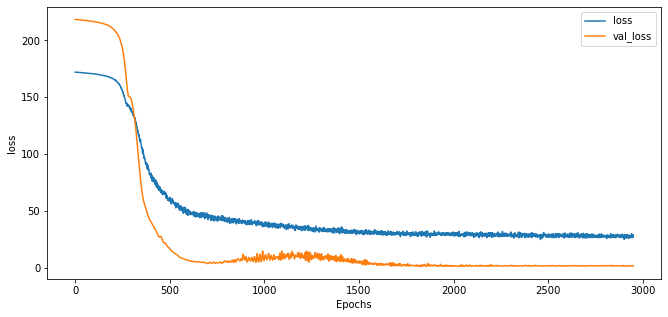

In [23]:
tf.random.set_seed(1265)

o1=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(12, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.45))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer=o1, loss='mse', metrics=["mae"])

model.summary()

# fit model
history=model.fit(X, y, epochs=3000, verbose=1,validation_data=(XS_test,yS_test),batch_size=len(X))

##### Plot the training and validation loss

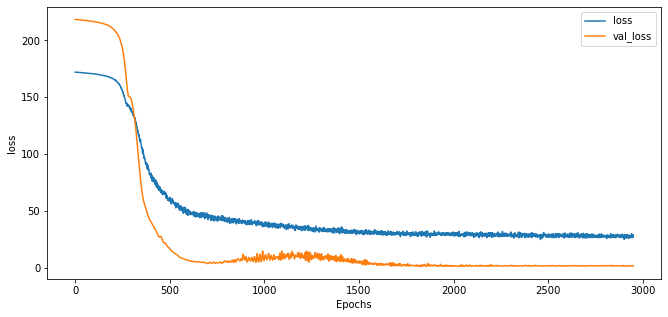

In [30]:
plot_graphs(history, 'loss')

## We check how does the model perform

In [25]:
U=np.zeros((8, 17))
Rs= [None] * 17

j=0
aux1=df1.diff()
aux2=aux1.diff()
aux3 = scaler.transform(aux2)
aux4=scaler.transform(df1)
i=88
for i in range(72,89):
    aux5=df1[0:i]  
    datos_entrada=aux4[(i-n_steps_in):(i)]
    datos_entrada=pd.DataFrame(datos_entrada).to_numpy()
    datos_entrada2=datos_entrada.reshape(1,n_steps_in,n_features)
    yhat = model.predict(datos_entrada2, verbose=0)
    yhat=yhat.reshape(n_steps_out)
    Yp=yhat
    Yp2=np.concatenate((aux5["Unem"],Yp))
    Rs[j]= Yp2
    Rv=df1["Unem"][0:(i+n_steps_out)].to_numpy()
    l=np.zeros((8))    
    l2=Rv[(i):(i+n_steps_out)]
    l[0:len(l2)]=l2
    a2= Yp2[(i):(i+n_steps_out)]
    a3=np.zeros(8) 
    a3[0:len(l2)]=a2[0:len(l2)]
    R=l-a3
    U[:,j]=R
    j=j+1
    
U=abs(U)

# Performance comparison

### We load the error matrix of the VAR model

In [31]:
U_R=pd.read_csv("SPAIN/U_R.csv")

### We calculate the mae for each timestep for both models  & and the mean of this values

In [32]:
U[U == 0] = np.nan
ULS=np.nanmean(U,axis=1)
np.mean(ULS)
    
    #     VAR model 
UR=np.nanmean(U_R,axis=1)
np.mean(UR)

2.198892756258478

# Interactive visualization of the performance

### Data preprocessing

In [33]:
ULS=ULS.reshape(8,1)
UR=UR.reshape(8,1)

U1=pd.DataFrame(ULS).set_axis(["mae"],axis=1)
U1["Model"]="LSTM"
U1["N step ahead"]=np.arange(1,9)

U2=pd.DataFrame(UR).set_axis(["mae"],axis=1)
U2["Model"]="VAR"
U2["N step ahead"]=np.arange(1,9)

U3=pd.concat([U1,U2])

### Data visualization

In [38]:

fig = px.scatter(U3, x="N step ahead", y="mae", color="Model",width=900, height=500,color_discrete_sequence=["red", "blue"])
fig.update_traces(marker=dict(size=30,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(
     title=dict(
        text='<b>Model</b>',
        x=0.45,
        y=0.97,
        font=dict(
            family="Arial",
            size=25,
            color='#000000'
        )
    ),

)


fig.show()